In [ ]:
import json
import gcsfs
# dir = C:\Users\annab\Desktop\ArgoEKE\github-argo-eke\data\
fp = r"C:\Users\annab\Desktop\ArgoEKE\pangeo-181919-e7bc5bdaf4d5.json" # dir+r'pangeo-181919-e7bc5bdaf4d5.json' #
with open(fp) as f:
    token = json.load(f)
gcs = gcsfs.GCSFileSystem(token=token) # file system instance
bucket_pth = 'pangeo-argo-eke/'
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
plt.rcParams['figure.dpi'] = 450
import xarray as xr
import numpy as np
from cartopy.util import add_cyclic_point;
import os
import datetime
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LogNorm
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from mpl_params import *
plt.rcParams.update(mpl_params())
import cmocean
# plt.rcParams.update(mpl_params(font_family='serif'))
# import cmocean

# set the cwd to be the parent directory 
# os.chdir(os.path.dirname(os.getcwd()))
print('Current working directory: ', os.getcwd())

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='cartopy')

Current working directory:  c:\Users\annab\Desktop\ArgoEKE\aies-argo\moca_comparison


In [4]:
# argo_m = curr_argo_ds
argo_m = xr.open_dataset('AGVA_timemean_subset_MOCA_comparison.nc'
                         )
curr_argo_ds = argo_m
argo_m

<xarray.Dataset> Size: 221MB
Dimensions:    (latitude: 641, longitude: 719, pressure: 30)
Coordinates:
  * latitude   (latitude) float64 5kB -80.0 -79.75 -79.5 ... 79.5 79.75 80.0
  * longitude  (longitude) float64 6kB -179.5 -179.0 -178.5 ... 179.0 179.5
  * pressure   (pressure) float64 240B 0.0 5.0 10.0 ... 1.8e+03 1.9e+03 2e+03
Data variables:
    u          (latitude, longitude, pressure) float64 111MB ...
    v          (latitude, longitude, pressure) float64 111MB ...
Attributes:
    description:          Timemean of gridded velocity estimates
    number_of_harmonics:  2
    window_size:          500000.0
    filename:             pangeo-argo-eke/testfolder_127/timemean_velocity_pr...
    residualfilepath:     pangeo-argo-eke/testfolder_112/vel_argolocation_res...
    uvfitfile:            pangeo-argo-eke/testfolder_112/global_uvfit_absMSE....
    covparamfilepath:     pangeo-argo-eke/testfolder_118/vel_covparams_AgeoOn...
    created_date:         2024-11-12 17:46:14.002224

In [16]:
MOCA_ds = xr.open_dataset(os.path.join(os.getcwd(), 'MOCA2000dbar_CenterYear2010_EOS80_v1_1.nc'))
    # gcs.get_mapper('pangeo-argo-eke/climatology/drifter/drifter_monthlymeans.nc'))
MOCA_ds

# Get original MOCA longitudes
moca_lon = MOCA_ds.LONGITUDE.values.copy()

# Convert from [0,360] to [-180,180)
moca_lon = np.where(moca_lon > 180, moca_lon - 360, moca_lon)
moca_lon = np.where(moca_lon <= -180, moca_lon + 360.0, moca_lon)

# Remove duplicates (keep first occurrence) -- repeat at 0 deg longitude after conversion
_, unique_indices = np.unique(moca_lon, return_index=True)
unique_indices = np.sort(unique_indices)
moca_lon = moca_lon[unique_indices]

curr_argo_ds = argo_m
# Restrict longitudes to Argo range
argo_lon = curr_argo_ds.longitude.values
argo_min, argo_max = argo_lon.min(), argo_lon.max()
print('argo LON min, argo LON max', argo_min, argo_max)
lon_mask = (moca_lon >= argo_min) & (moca_lon <= argo_max)
moca_lon = moca_lon[lon_mask]
unique_indices = unique_indices[lon_mask]

sort_idx = np.argsort(moca_lon)
moca_lon = moca_lon[sort_idx]
unique_indices = unique_indices[sort_idx]
MOCA_ds = MOCA_ds.isel(lon=unique_indices)
print(0, MOCA_ds.lon.values.min(), MOCA_ds.lon.values.max(), MOCA_ds.lon.values[:3], MOCA_ds.lon.values[-3:] ) 
# Update MOCA_ds lon coord and LONGITUDE variable
MOCA_ds = MOCA_ds.assign_coords(lon=moca_lon)
MOCA_ds = MOCA_ds.assign(LONGITUDE=("lon", moca_lon))

# Sanity checking results
print("MOCA_ds longitude range:", MOCA_ds.lon.min().item(), MOCA_ds.lon.max().item())
print("MOCA_ds longitude count:", len(MOCA_ds.lon))
print(1, MOCA_ds.LONGITUDE.values.min(), MOCA_ds.LONGITUDE.values.max(), MOCA_ds.LONGITUDE.values[:3], MOCA_ds.LONGITUDE.values[-3:] ) 
print(2, MOCA_ds.lon.values.min(), MOCA_ds.lon.values.max(), MOCA_ds.lon.values[:3], MOCA_ds.lon.values[-3:] ) 


argo LON min, argo LON max -179.5 179.5
0 0 718 [0 1 2] [716 717 718]
MOCA_ds longitude range: -179.5 179.5
MOCA_ds longitude count: 719
1 -179.5 179.5 [-179.5 -179.  -178.5] [178.5 179.  179.5]
2 -179.5 179.5 [-179.5 -179.  -178.5] [178.5 179.  179.5]


In [17]:
MOCA_lat = MOCA_ds.LATITUDE.values; MOCA_lon=MOCA_ds.LONGITUDE.values

argo_plevels = [0,5,10,20,30,50,75,100,125,150,200,250,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
MOCA_plevels = list(MOCA_ds.PRES.values)
shared_plevels = list(set(argo_plevels) & set(MOCA_plevels))
shared_plevels.sort()
print('shared_plevels', shared_plevels)


shared_plevels [0, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]


In [ ]:
# def extract_save_vel_subset(lats=None, lons=None, save_fn='', save=True):
#     curr_argo_ds = xr.open_dataset(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'timemean_velocity_product_nu72version.nc')) # load the dataset    
#     # Apply latitude/longitude selection
#     if lats is not None:
#         curr_argo_ds = curr_argo_ds.sel(latitude=lats)
#     if lons is not None:
#         curr_argo_ds = curr_argo_ds.sel(longitude=lons)

#     print(curr_argo_ds)
#     if save:
#         curr_argo_ds.to_netcdf(f'{save_fn}.nc')
#         # subset.close()
#     return curr_argo_ds

# argo_m = extract_save_vel_subset(lats=MOCA_lat, lons=MOCA_lon, save_fn='AGVA_timemean_subset_MOCA_comparison')

In [18]:
MOCA_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 641, lon: 719, pres: 82)
Coordinates:
  * lon        (lon) float64 6kB -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Dimensions without coordinates: lat, pres
Data variables: (12/15)
    LATITUDE   (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 79.5 79.75 80.0
    LONGITUDE  (lon) float64 6kB -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    PRES       (pres) float32 328B 0.0 5.0 10.0 15.0 ... 1.9e+03 1.95e+03 2e+03
    PSAL_m     (pres, lat, lon) float32 151MB ...
    PSAL_se    (pres, lat, lon) float32 151MB ...
    PTMP_m     (pres, lat, lon) float32 151MB ...
    ...         ...
    UGEO_m     (pres, lat, lon) float32 151MB ...
    UGEO_se    (pres, lat, lon) float32 151MB ...
    VGEO_m     (pres, lat, lon) float32 151MB ...
    VGEO_se    (pres, lat, lon) float32 151MB ...
    GPAN_m     (pres, lat, lon) float32 151MB ...
    GPAN_se    (pres, lat, lon) float32 151MB ...
Attributes:
    title:          Mesoscale Ocean Circulation Atlas (MOCA2000_2020)
    institution:    Woods Hole Oceanographic Institution
    source:         Robust parametric fit to Argo profiles (2000-2020, Dec 20...
    source_infill:  Regions where the mapped error is large and in the Arctic...
    error_coding:   Standard Errors are supplied for each variable except: me...
    infill_coding:  Infill points marked by SE=-999
    creation_date:  2025-05-29T13:37:06Z
    reference:      Wijffels, S.E., G. Gebbie and P. E. Robbins, J. Phys Ocea...
    comment:        Please cite the reference when you use this product, and ...
    center_time:    Atlas is a 20 year average centered on the year 2010
    version:        1.1

In [19]:
MOCA_lat[:5], MOCA_lat[-5:],MOCA_lon[:5], MOCA_lon[-5:]

(array([-80.  , -79.75, -79.5 , -79.25, -79.  ]),
 array([79.  , 79.25, 79.5 , 79.75, 80.  ]),
 array([-179.5, -179. , -178.5, -178. , -177.5]),
 array([177.5, 178. , 178.5, 179. , 179.5]))

In [69]:
argo_m_lat = argo_m.latitude.values
argo_m_lon = argo_m.longitude.values
argo_m.latitude.values[:5], argo_m.latitude.values[-5:], argo_m.longitude.values[:5], argo_m.longitude.values[-5:]

(array([-80.  , -79.75, -79.5 , -79.25, -79.  ]),
 array([79.  , 79.25, 79.5 , 79.75, 80.  ]),
 array([-179.5, -179. , -178.5, -178. , -177.5]),
 array([177.5, 178. , 178.5, 179. , 179.5]))

In [24]:
def plot_1d_diff_field(diff_arr, latitudes, longitudes, title, cmap=cmocean.cm.balance, vmin=None, vmax=None,
                       lognorm=None, premade_ax=False, plevel=None):
    if not premade_ax:
        ax = map_params(figsize=(10,6))
    else:
        ax = premade_ax
    ax.set_title(title, fontsize=12)

    print(longitudes.shape, latitudes.shape, diff_arr.shape)
    mesh = ax.contourf(longitudes, latitudes, diff_arr,
                       levels=500,
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree())
                       # norm=lognorm)  # uncomment if you want to use lognorm

    if not premade_ax:
        plt.show()

    return ax

def plot_field(arr, latitudes, longitudes, title, cmap=cmocean.cm.curl, vmin=None, vmax=None,lognorm=None, premade_ax=False, cbar=True, plevel=None):
    if not premade_ax:
        ax = map_params(figsize=(10,6))
    else:
        ax = premade_ax
    ax.set_title(title, fontsize=12)

    cbar_label = f'Velocity at {plevel} dbar (m/s)'
    # print(longitudes.shape, latitudes.shape, arr.shape)
    mesh = ax.contourf(longitudes, latitudes, arr,
                       levels=500,
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree())
                       # norm=lognorm)  # uncomment if you want to use lognorm

    if cbar:
        extend = 'both' if vmin is not None and vmax is not None else 'neither'
        plt.colorbar(mesh, ax=ax, orientation='horizontal', label=cbar_label, extend=extend)
    
    if not premade_ax:
        plt.show()

    return ax

In [ ]:
# mask out <2 degrees of latitude around the equator
cond=np.logical_or(argo_m.latitude > 2, argo_m.latitude < -2)
argo_m = argo_m.where(cond)

In [20]:
cond = np.logical_or(MOCA_ds.LATITUDE > 2, MOCA_ds.LATITUDE < -2)
MOCA_ds = MOCA_ds.where(cond)
MOCA_lat = MOCA_ds.LATITUDE.values
argo_m, MOCA_ds

(<xarray.Dataset> Size: 221MB
 Dimensions:    (latitude: 641, longitude: 719, pressure: 30)
 Coordinates:
   * latitude   (latitude) float64 5kB -80.0 -79.75 -79.5 ... 79.5 79.75 80.0
   * longitude  (longitude) float64 6kB -179.5 -179.0 -178.5 ... 179.0 179.5
   * pressure   (pressure) float64 240B 0.0 5.0 10.0 ... 1.8e+03 1.9e+03 2e+03
 Data variables:
     u          (latitude, longitude, pressure) float64 111MB nan nan ... nan nan
     v          (latitude, longitude, pressure) float64 111MB nan nan ... nan nan
 Attributes:
     description:          Timemean of gridded velocity estimates
     number_of_harmonics:  2
     window_size:          500000.0
     filename:             pangeo-argo-eke/testfolder_127/timemean_velocity_pr...
     residualfilepath:     pangeo-argo-eke/testfolder_112/vel_argolocation_res...
     uvfitfile:            pangeo-argo-eke/testfolder_112/global_uvfit_absMSE....
     covparamfilepath:     pangeo-argo-eke/testfolder_118/vel_covparams_AgeoOn...
     cr

In [75]:
argo_m_lon

array([-179.5, -179. , -178.5, -178. , -177.5, -177. , -176.5, -176. ,
       -175.5, -175. , -174.5, -174. , -173.5, -173. , -172.5, -172. ,
       -171.5, -171. , -170.5, -170. , -169.5, -169. , -168.5, -168. ,
       -167.5, -167. , -166.5, -166. , -165.5, -165. , -164.5, -164. ,
       -163.5, -163. , -162.5, -162. , -161.5, -161. , -160.5, -160. ,
       -159.5, -159. , -158.5, -158. , -157.5, -157. , -156.5, -156. ,
       -155.5, -155. , -154.5, -154. , -153.5, -153. , -152.5, -152. ,
       -151.5, -151. , -150.5, -150. , -149.5, -149. , -148.5, -148. ,
       -147.5, -147. , -146.5, -146. , -145.5, -145. , -144.5, -144. ,
       -143.5, -143. , -142.5, -142. , -141.5, -141. , -140.5, -140. ,
       -139.5, -139. , -138.5, -138. , -137.5, -137. , -136.5, -136. ,
       -135.5, -135. , -134.5, -134. , -133.5, -133. , -132.5, -132. ,
       -131.5, -131. , -130.5, -130. , -129.5, -129. , -128.5, -128. ,
       -127.5, -127. , -126.5, -126. , -125.5, -125. , -124.5, -124. ,
      

In [76]:
# Select plevel to visualize
def plot_argo_moca_fields(plevel, cbarlims = [-0.5,0.5], add_text='', argo_m=argo_m, MOCA_ds=MOCA_ds, MOCA_lon=MOCA_lon,
                          MOCA_lat=MOCA_lat , argo_lon=argo_m_lon, argo_lat=argo_m_lat):
    # plevel=10
    plevel_ind_argo = argo_plevels.index(plevel)
    plevel_ind_moca = MOCA_plevels.index(plevel)

    argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
    argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
    moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
    moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values

    # Add a cyclic point at -180 and 180 degrees in MOCA_ds
    moca_lvl_u, new_lon = add_cyclic_point(moca_lvl_u, coord=argo_m_lon)
    moca_lvl_v, new_lon = add_cyclic_point(moca_lvl_v, coord=argo_m_lon)
    MOCA_lon = new_lon
    argo_m_lvl_u, new_lon = add_cyclic_point(argo_m_lvl_u, coord=argo_m_lon)
    argo_m_lvl_v, new_lon = add_cyclic_point(argo_m_lvl_v, coord=argo_m_lon)

    moca_lvl_u, new_lon2 = add_cyclic_point(moca_lvl_u, coord=new_lon)
    moca_lvl_v, new_lon2 = add_cyclic_point(moca_lvl_v, coord=new_lon)
    MOCA_lon = new_lon2
    argo_m_lvl_u, new_lon2 = add_cyclic_point(argo_m_lvl_u, coord=new_lon)
    argo_m_lvl_v, new_lon2 = add_cyclic_point(argo_m_lvl_v, coord=new_lon)

    fig = plt.figure(figsize=(16,8))
    gs = fig.add_gridspec(2,3, width_ratios=[1, 1, 0.03], wspace=0.05)
    ax1 = fig.add_subplot(gs[0, 0], projection= ccrs.PlateCarree(central_longitude=-159.75)); _, ax1, _ ,_ = map_params(premade_ax=ax1)
    ax2 = fig.add_subplot(gs[1, 0], projection= ccrs.PlateCarree(central_longitude=-159.75)); _, ax2, _ ,_  = map_params(premade_ax=ax2)
    ax3 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=-159.75)); _, ax3, _ ,_  = map_params(premade_ax=ax3)
    ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=-159.75)); _, ax4, _ ,_  = map_params(premade_ax=ax4)
    cbar_ax = fig.add_subplot(gs[:, 2])  # full height of 3rd column

    plot_field(argo_m_lvl_u, MOCA_lat, MOCA_lon, title=f'AGVA Zonal Velocity, $u$', premade_ax=ax1, vmin=cbarlims[0], vmax=cbarlims[1], cbar=False, plevel=plevel)
    plot_field(argo_m_lvl_v, MOCA_lat, MOCA_lon, title=f'AGVA Meridional Velocity, $v$', premade_ax=ax2, vmin=cbarlims[0], vmax=cbarlims[1], cbar=False, plevel=plevel)
    plot_field(moca_lvl_u, MOCA_lat, MOCA_lon, title=f'MOCA Zonal Velocity, $u$', premade_ax=ax3, vmin=cbarlims[0], vmax=cbarlims[1], cbar=False, plevel=plevel)
    plot_field(moca_lvl_v, MOCA_lat, MOCA_lon, title=f'MOCA Meridional Velocity, $v$', premade_ax=ax4, vmin=cbarlims[0], vmax=cbarlims[1] , cbar=False, plevel=plevel)

    sm = mpl.cm.ScalarMappable(cmap=cmocean.cm.curl, norm=mpl.colors.Normalize(vmin=cbarlims[0], vmax=cbarlims[1]))
    # cbarlims = [-0.5,0.5]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
    cbar.set_label(f'Velocity at {plevel} m (m/s)')

    if True:
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.savefig(f'figures/maps_vel_{plevel}dbar{add_text}.png', dpi=450, bbox_inches='tight')
        plt.show()
    plt.show()

C:\Users\annab\AppData\Local\Temp\ipykernel_15544\1058600859.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


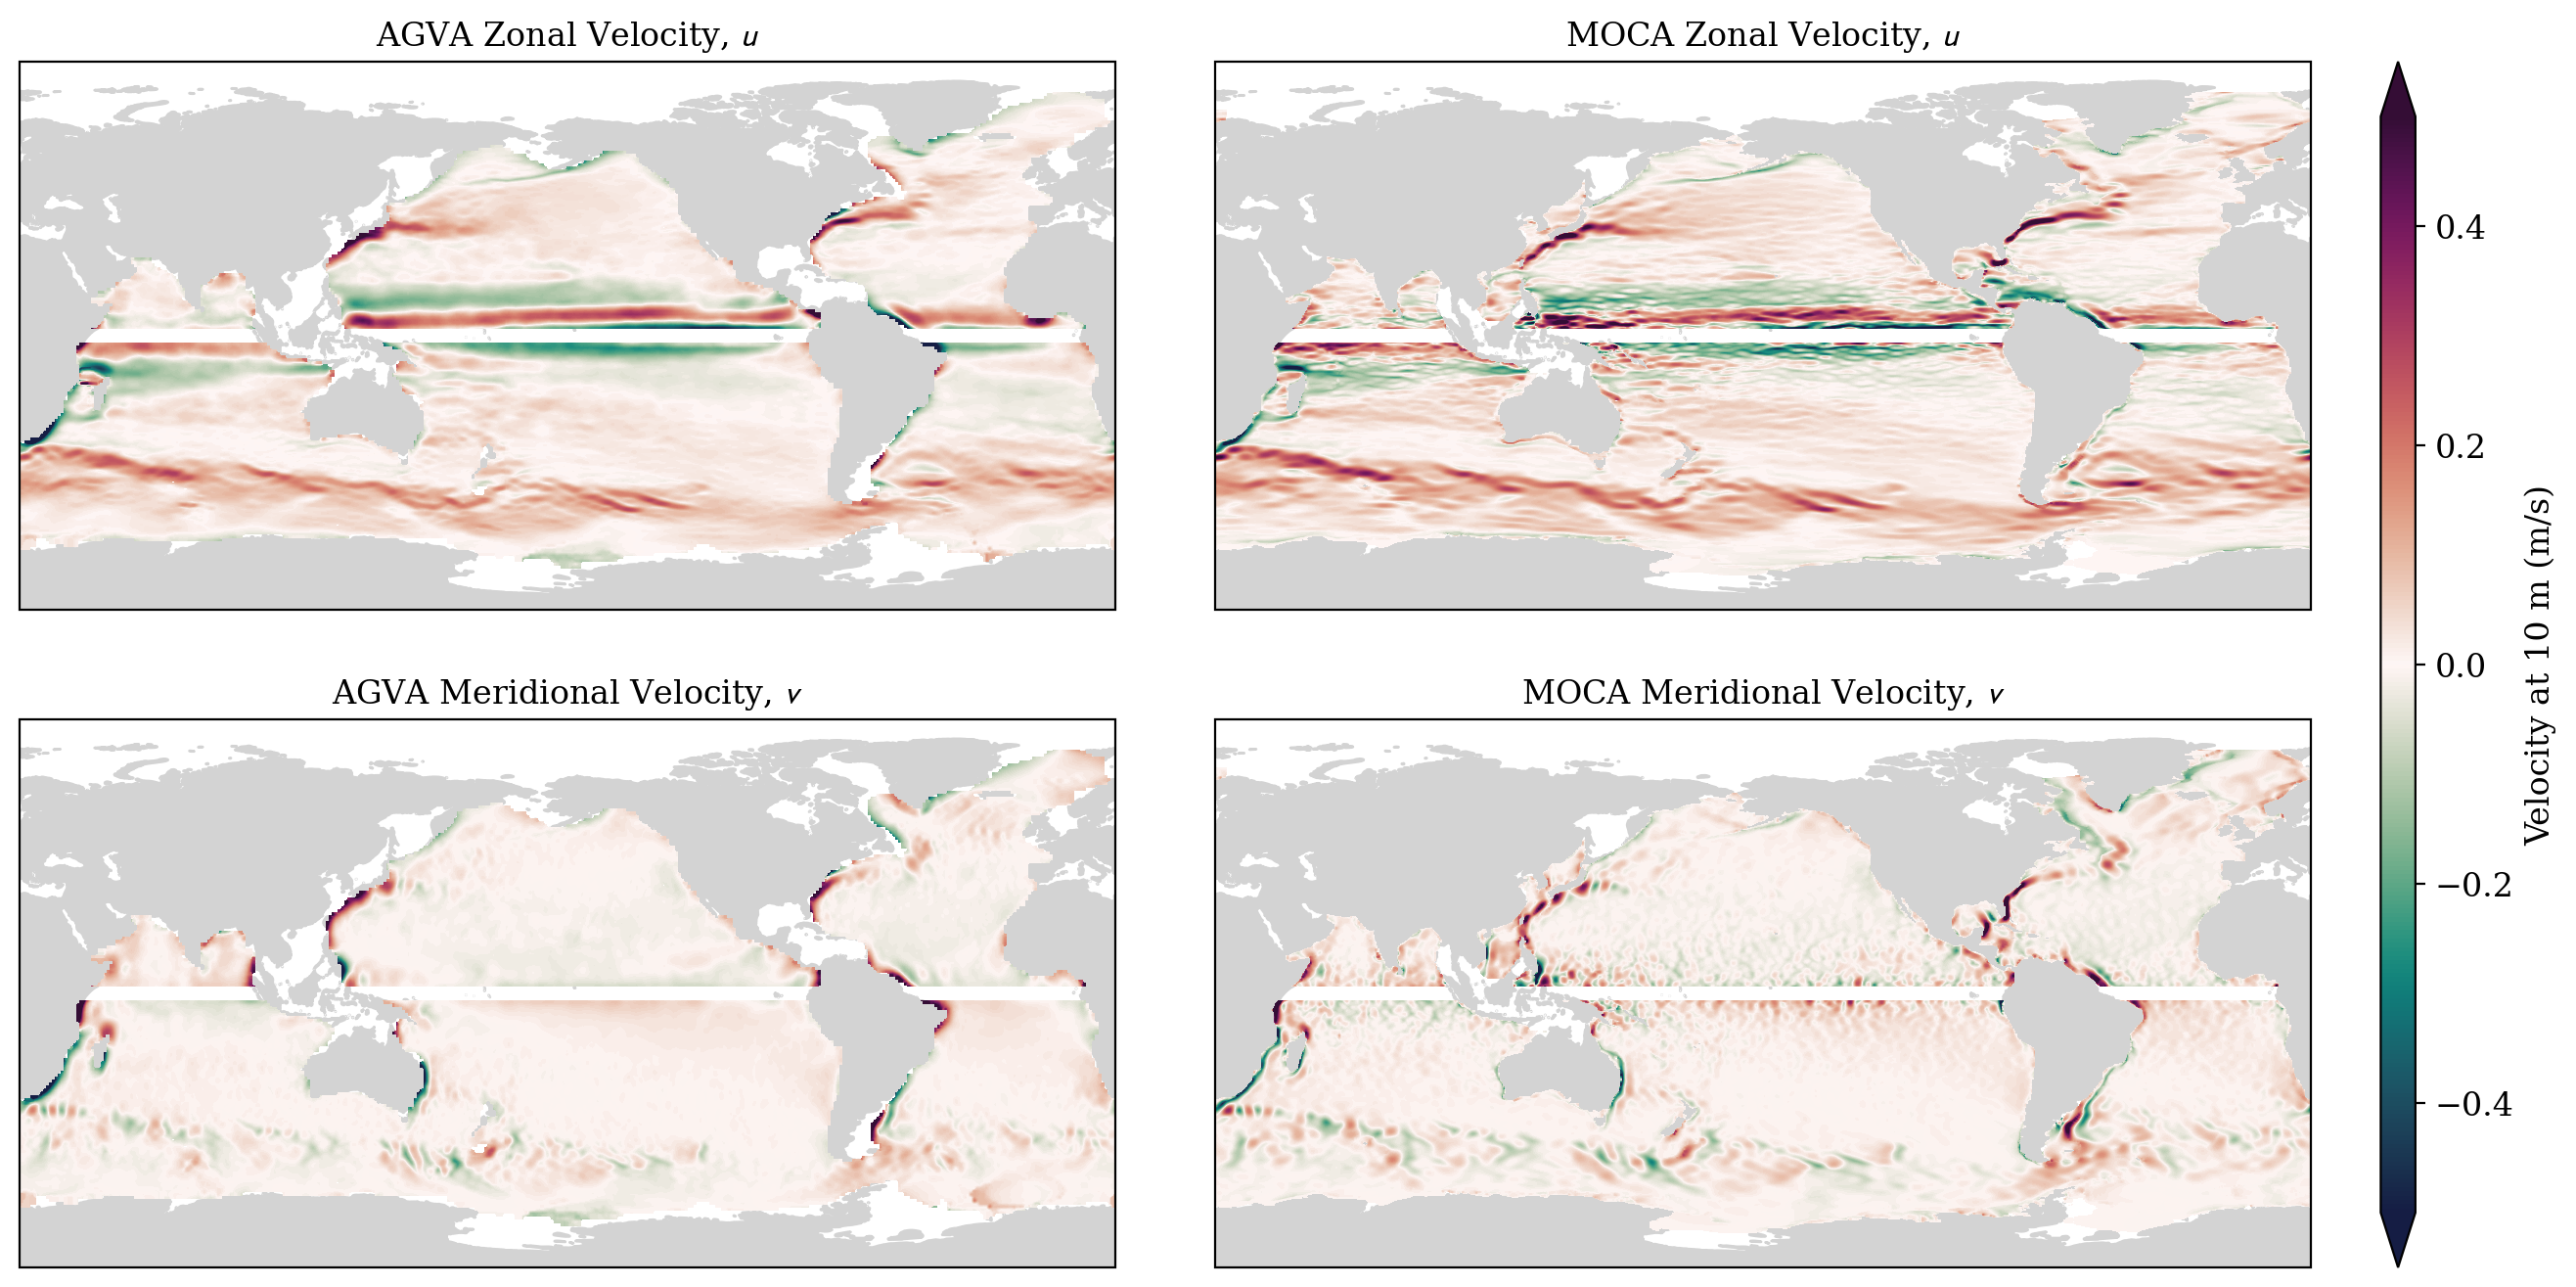

C:\Users\annab\AppData\Local\Temp\ipykernel_15544\1058600859.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


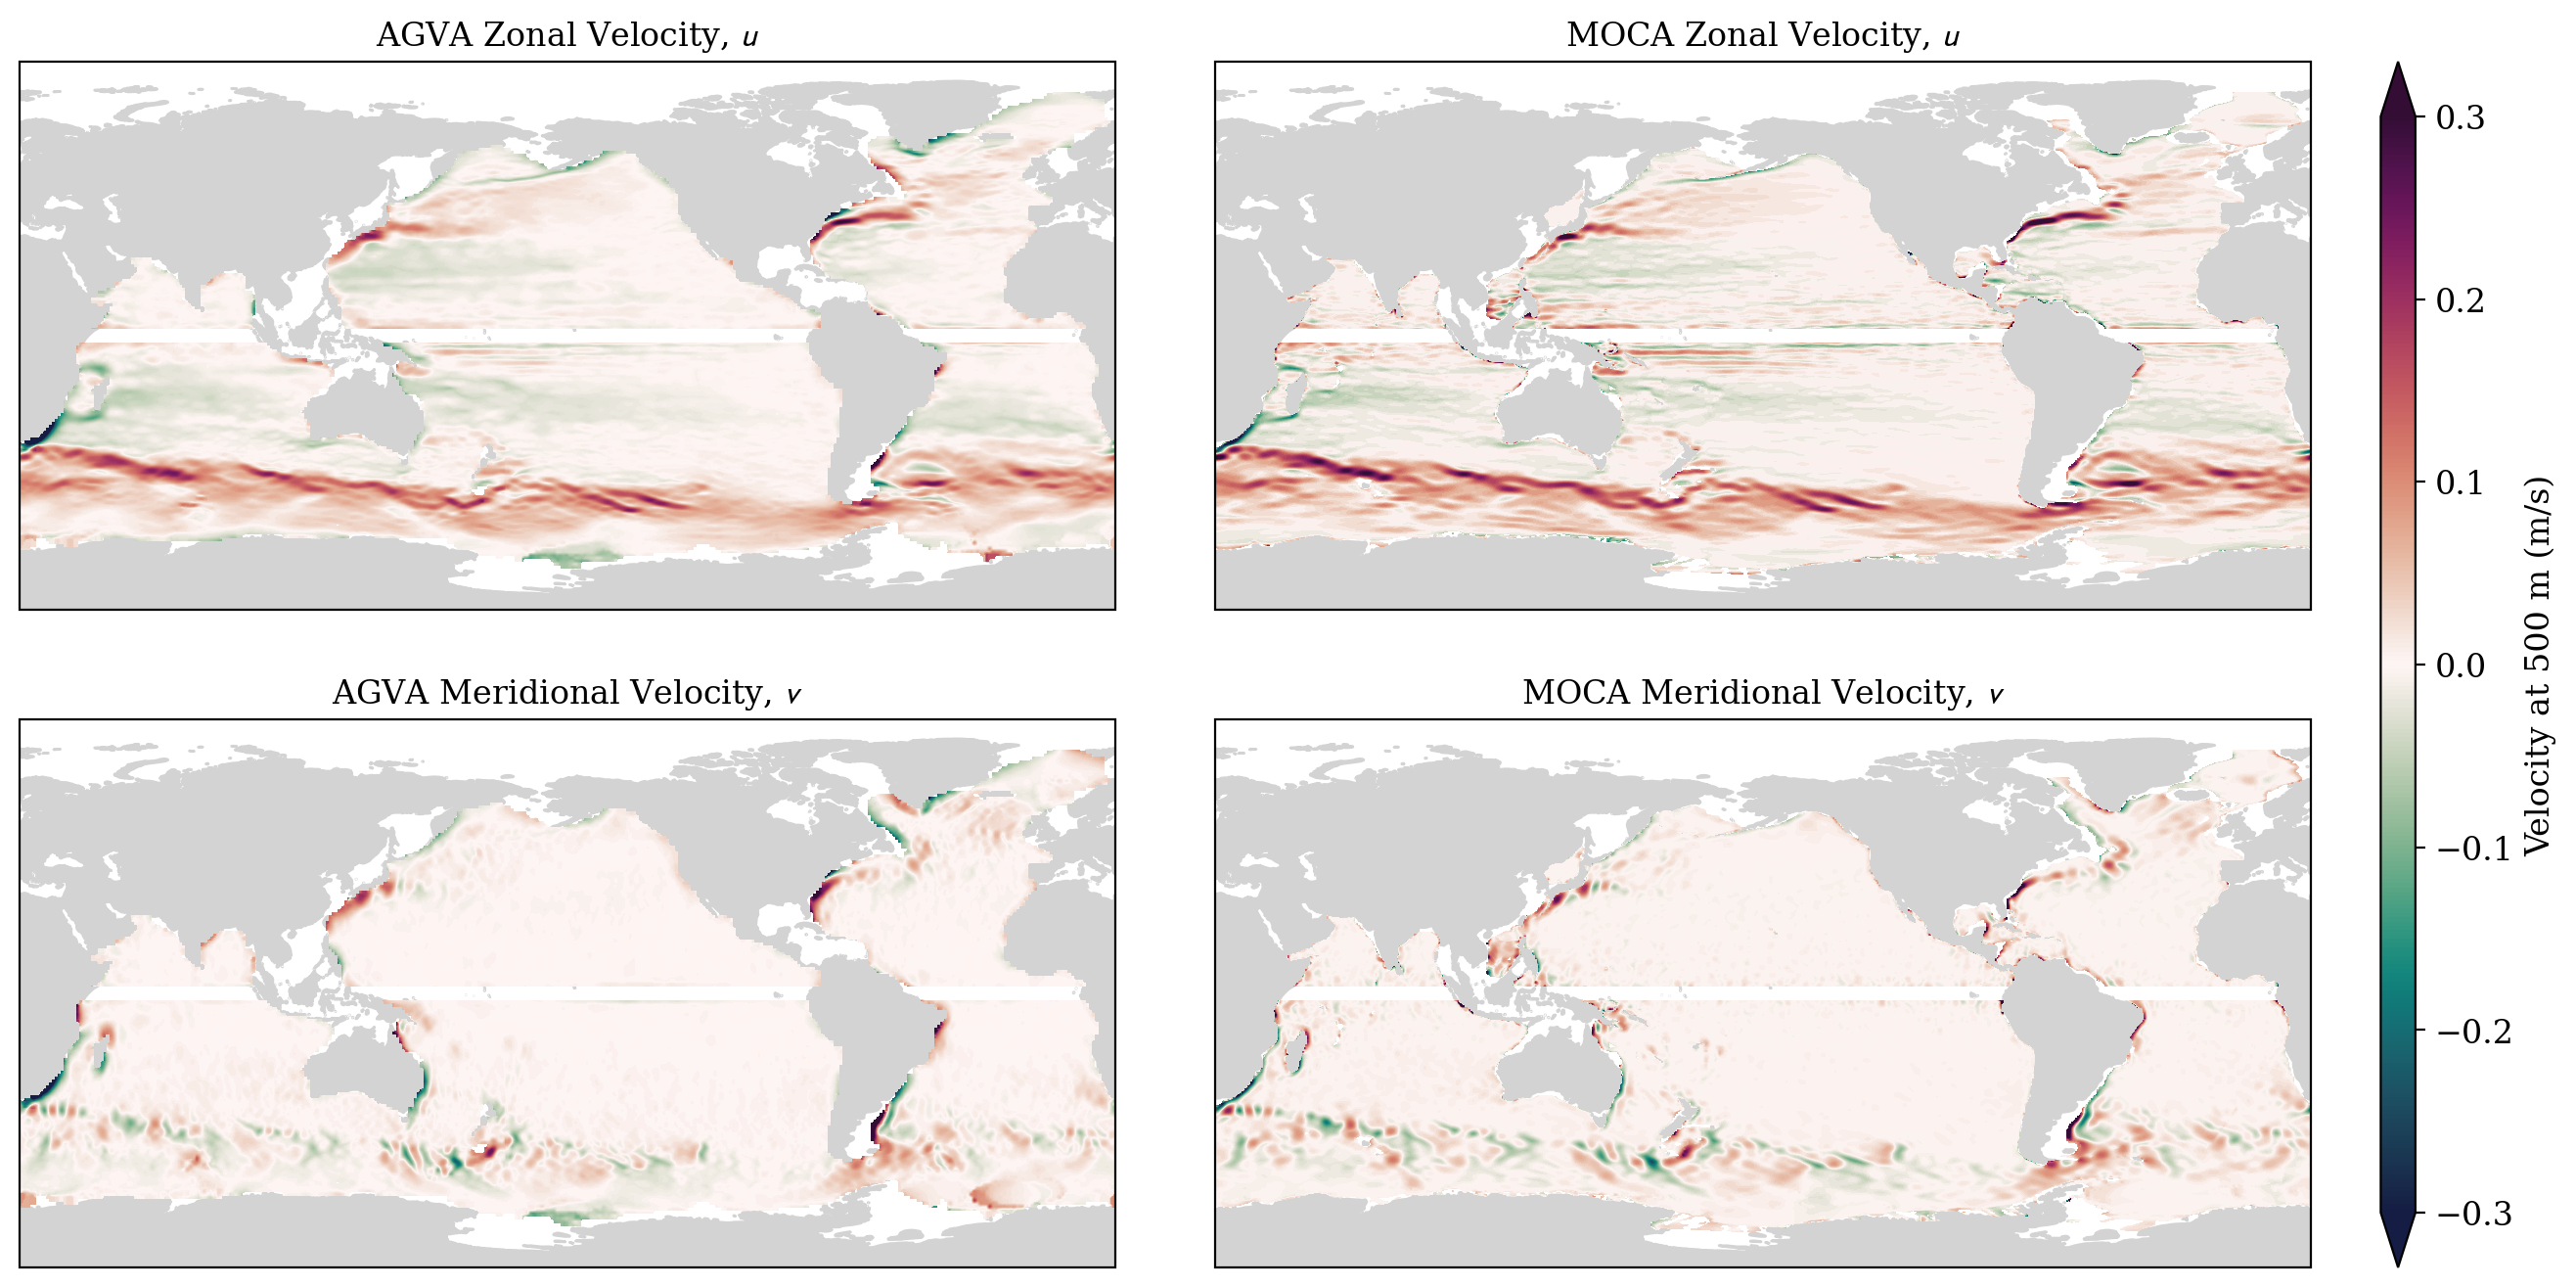

C:\Users\annab\AppData\Local\Temp\ipykernel_15544\1058600859.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


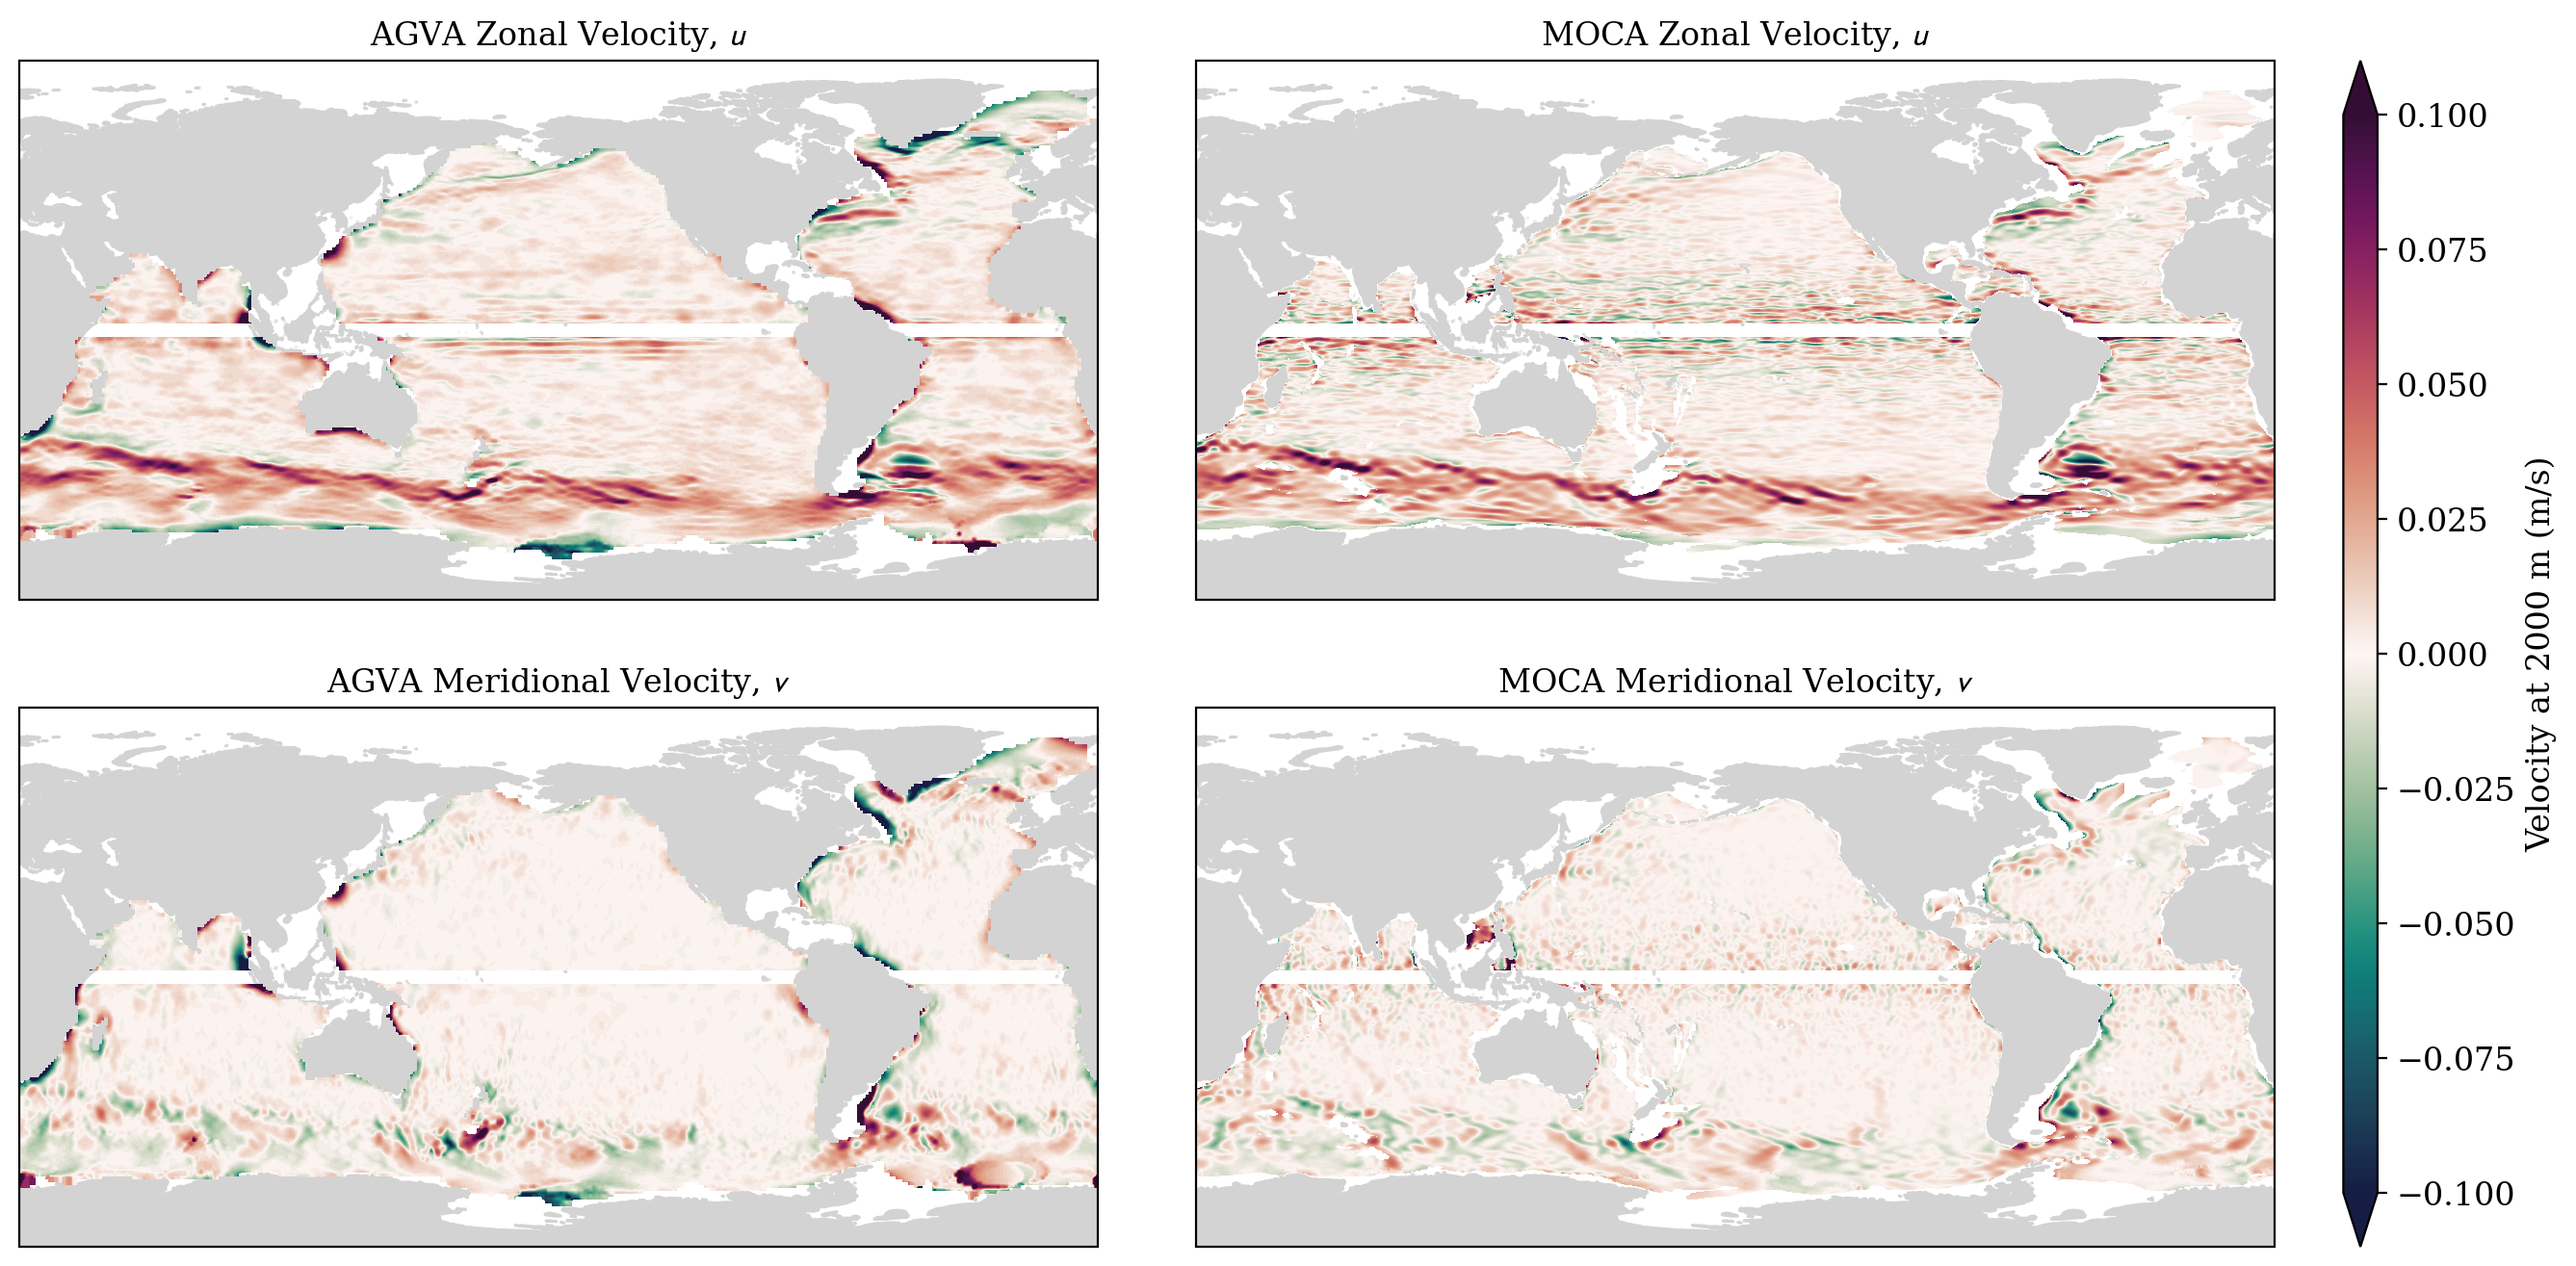

In [77]:
plot_argo_moca_fields(10)
# plot_argo_moca_fields(250, cbarlims=[-0.4,0.4])
plot_argo_moca_fields(500, cbarlims=[-0.3,0.3], add_text='cbar0.3')
# plot_argo_moca_fields(1000, cbarlims=[-0.2,0.2], add_text='cbar0.2')
plot_argo_moca_fields(2000, cbarlims=[-0.1,0.1], add_text='cbar0.1')

In [27]:
def plot_histogram_comparison(arr1, arr2, label1='AGVA', label2='MOCA', bins=45, title='Histogram Comparison', xlabel='Velocity (m/s)', ylabel='density', log=False,plevel=None,premade_ax=None, legend=False):
    arr1 = arr1.flatten()
    arr2 = arr2.flatten()
    if not premade_ax: 
        fig, ax = plt.subplots()
    else:
        ax=premade_ax
    
    ax.hist(arr1, bins=bins, alpha=0.5, label=label1, color='blue', density=True, log=log)
    ax.hist(arr2, bins=bins, alpha=0.5, label=label2, color='orange', density=True, log=log)
    ax.set_xlim([-0.5,0.5])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend:
        plt.legend()
    plt.grid()
    # plt.show()

In [ ]:
def plot_argo_moca_histogram(plevel):
    # plevel=10
    plevel_ind_argo = argo_plevels.index(plevel)
    plevel_ind_moca = MOCA_plevels.index(plevel)

    argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
    argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
    moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
    moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values

    bins=np.linspace(-0.5,0.5,100)
    plot_histogram_comparison(argo_m_lvl_u, moca_lvl_u, bins=bins, title=f'Zonal Velocity $u$ Histogram Comparison at {plevel} dbar', plevel=plevel)
    plot_histogram_comparison(argo_m_lvl_v, moca_lvl_v, bins=bins, title=f'Meridional Velocity $v$ Histogram Comparison at {plevel} dbar', plevel=plevel)

# Select plevel to visualize
def plot_argo_moca_hist_gridspec(plevel1=None, plevel2=None):
    plevel=plevel1
    plevel_ind_argo = argo_plevels.index(plevel)
    plevel_ind_moca = MOCA_plevels.index(plevel)

    argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
    argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
    moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
    moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values

    fig = plt.figure(figsize=(18,8))
    gs = fig.add_gridspec(2,2, 
                        #   width_ratios=[1.2, 1.2,], wspace=0.15
                          )
    ax1 = fig.add_subplot(gs[0, 0]);# ax1 = map_params(premade_ax=ax1)
    ax2 = fig.add_subplot(gs[0, 1]) ;# ax2 = map_params(premade_ax=ax2)
    ax3 = fig.add_subplot(gs[1, 0]); #ax3 = map_params(premade_ax=ax3)
    ax4 = fig.add_subplot(gs[1, 1]); #ax4 = map_params(premade_ax=ax4)
    # cbar_ax = fig.add_subplot(gs[:, 2])  # full height of 3rd column

    bins=np.linspace(-0.5,0.5,1000)
    plot_histogram_comparison(argo_m_lvl_u, moca_lvl_u, bins=bins, title=f'Zonal Velocity $u$ Histogram Comparison at {plevel} dbar', plevel=plevel,  premade_ax=ax1, legend=True)
    plot_histogram_comparison(argo_m_lvl_v, moca_lvl_v, bins=bins, title=f'Meridional Velocity $v$ Histogram Comparison at {plevel} dbar', plevel=plevel, premade_ax=ax2,)

    plevel=plevel2 
    plevel_ind_argo = argo_plevels.index(plevel)
    plevel_ind_moca = MOCA_plevels.index(plevel)
    argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
    argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
    moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
    moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values
    bins=np.linspace(-0.5,0.5,1000)
    plot_histogram_comparison(argo_m_lvl_u, moca_lvl_u, bins=bins, title=f'Zonal Velocity $u$ Histogram Comparison at {plevel} dbar', plevel=plevel,  premade_ax=ax3)
    plot_histogram_comparison(argo_m_lvl_v, moca_lvl_v, bins=bins, title=f'Meridional Velocity $v$ Histogram Comparison at {plevel} dbar', plevel=plevel, premade_ax=ax4,)

    if True:
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.savefig(f'figures/supplot_hist_{plevel1}dbar_{plevel2}dbar.png', dpi=450, bbox_inches='tight')
        plt.show()
    plt.show()

C:\Users\annab\AppData\Local\Temp\ipykernel_15544\479252129.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


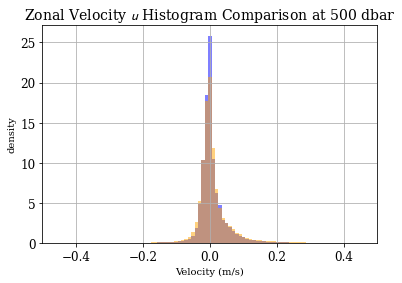

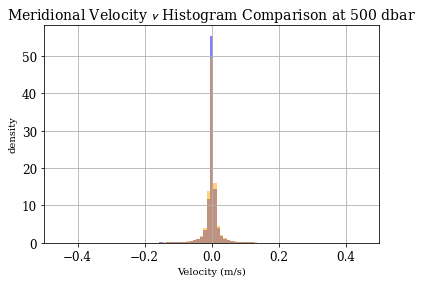

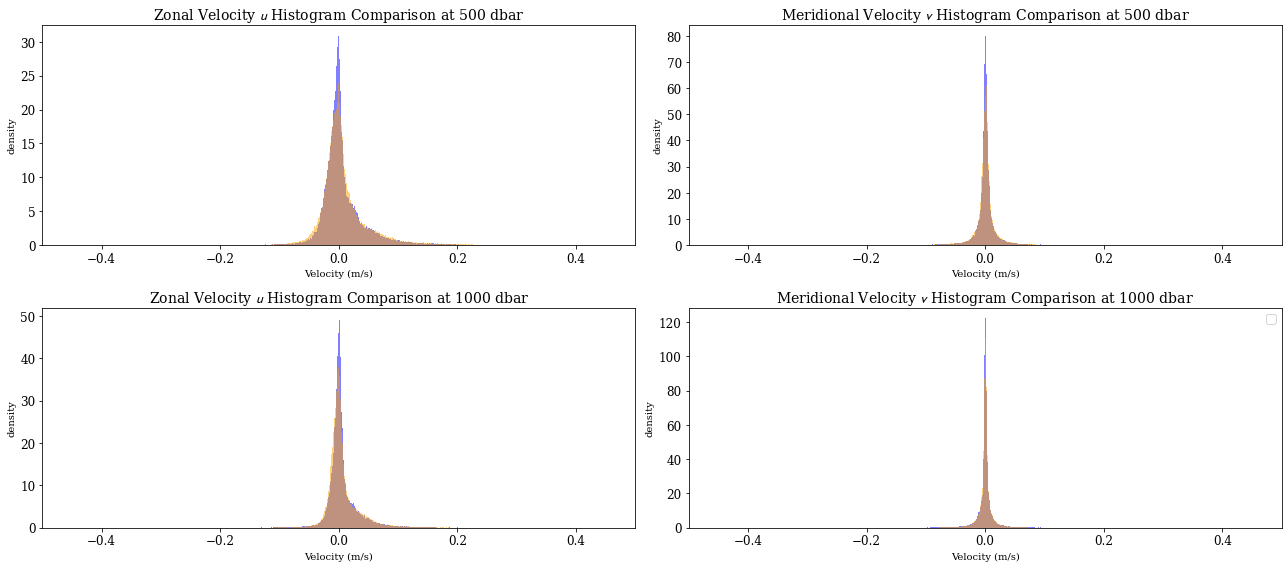

In [29]:
# plot_argo_moca_histogram(10)
# plot_argo_moca_histogram(250)
plot_argo_moca_histogram(500)
# plot_argo_moca_histogram(1000)
# plot_argo_moca_histogram(2000)

plot_argo_moca_hist_gridspec(500,1000)

In [ ]:
def heatmap_comparison(moca_ds, argo_ds, title, vel_type='', premade_ax=False, xylims=[-1.5,1.5]): 
    moca_flat = moca_ds.flatten()
    argo_flat = argo_ds.flatten()

    # Remove NaNs from both arrays
    mask = ~np.isnan(moca_flat) & ~np.isnan(argo_flat)
    moca_clean = moca_flat[mask]
    argo_clean = argo_flat[mask]

    if not premade_ax:
        fig,ax = plt.subplots()
    else:
        ax=premade_ax

    bins = np.linspace(xylims[0],xylims[1],300)
    ax.hist2d(moca_clean, argo_clean, bins=bins, 
              density=True,
              cmap=cmocean.cm.thermal,
              norm=LogNorm()
    )
    min_val = xylims[0]
    max_val = xylims[1]
    ax.plot([min_val, max_val], [min_val, max_val], 'k-', alpha=0.2, label='$y=x$')
    # plt.scatter(drifter_clean, argo_clean, alpha=0.3, s=5)
    # min_val = -1.5 #min(drifter_u_clean.min(), argo_u_clean.min())
    # max_val = 1.5 #max(drifter_u_clean.max(), argo_u_clean.max())
    # plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
    ax.set_xlabel(f'MOCA {vel_type} velocity  (m/s)')
    ax.set_ylabel(f'AGVA {vel_type} velocity (m/s)')
    ax.set_title(title)
    ax.grid(linestyle='--', alpha=0.5)

    if not premade_ax:
        plt.tight_layout()
        plt.savefig(f'heatmap_{vel_type}.png', dpi=450, bbox_inches='tight')
        plt.show()

    return ax

C:\Users\annab\AppData\Local\Temp\ipykernel_15544\1507889450.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


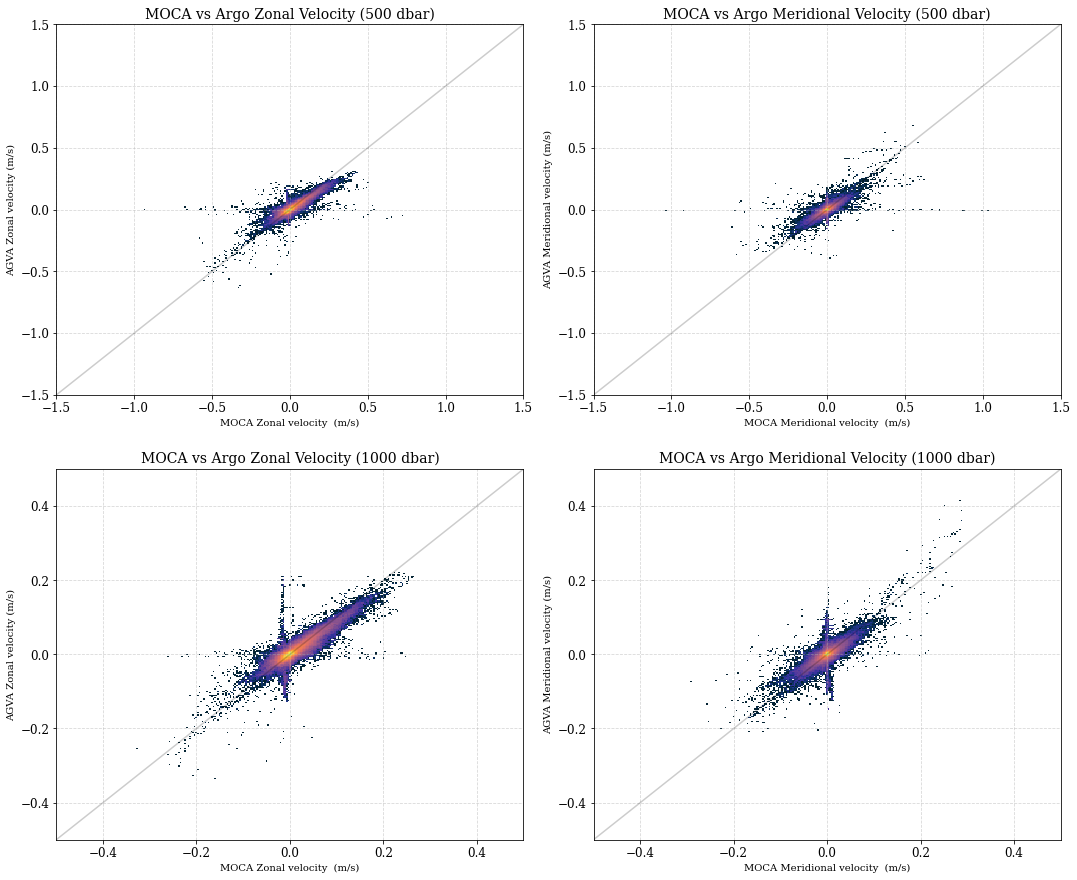

In [ ]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(2,2, width_ratios=[1, 1], wspace=0.15)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0,1]) 
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
# cbar_ax = fig.add_subplot(gs[:, 2])  # full height of 3rd column

plevel=500
plevel_ind_argo = argo_plevels.index(plevel)
plevel_ind_moca = MOCA_plevels.index(plevel)
argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values

ax1 = heatmap_comparison(moca_lvl_u, argo_m_lvl_u, title='MOCA vs Argo Zonal Velocity (500 dbar)', vel_type='Zonal', premade_ax=ax1)
ax2 = heatmap_comparison(moca_lvl_v, argo_m_lvl_v, title='MOCA vs Argo Meridional Velocity (500 dbar)', vel_type='Meridional', premade_ax=ax2)

plevel=1000
plevel_ind_argo = argo_plevels.index(plevel)
plevel_ind_moca = MOCA_plevels.index(plevel)
argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values
ax3 = heatmap_comparison(moca_lvl_u, argo_m_lvl_u, title='MOCA vs Argo Zonal Velocity (1000 dbar)', vel_type='Zonal', premade_ax=ax3, xylims=[-0.5,0.5])
ax4 = heatmap_comparison(moca_lvl_v, argo_m_lvl_v, title='MOCA vs Argo Meridional Velocity (1000 dbar)', vel_type='Meridional', premade_ax=ax4, xylims=[-0.5,0.5])

# sm = mpl.cm.ScalarMappable(cmap=cmocean.cm.balance, norm=mpl.colors.Normalize(vmin=-0.5, vmax=0.5))
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
# cbar.set_label('Velocity at 15 m (m/s)')

if True:
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'figures/heatmaps.png', dpi=450, bbox_inches='tight')
    plt.show()
plt.show()


In [46]:
MOCA_lon = MOCA_ds.LONGITUDE.values
MOCA_lon.shape, MOCA_lat.shape

((719, 641), (641,))

In [45]:
argo_lon = argo_m.longitude.values
argo_lon.shape

(719,)

In [78]:
# Select plevel to visualize
def plot_argo_moca_diffs(plevel, cbarlims = [-0.5,0.5], add_text='', lon = argo_m.longitude.values, lat = argo_m.latitude.values, argo_m=argo_m, MOCA_ds=MOCA_ds):
    # plevel=10
    plevel_ind_argo = argo_plevels.index(plevel)
    plevel_ind_moca = MOCA_plevels.index(plevel)
    argo_m_lvl_u = argo_m.isel(pressure=plevel_ind_argo).u.values
    argo_m_lvl_v = argo_m.isel(pressure=plevel_ind_argo).v.values
    moca_lvl_u = MOCA_ds.isel(pres=plevel_ind_moca).UGEO_m.values
    moca_lvl_v = MOCA_ds.isel(pres=plevel_ind_moca).VGEO_m.values

    fig = plt.figure(figsize=(20,5))
    gs = fig.add_gridspec(1,3, width_ratios=[1, 1, 0.03], wspace=0.15)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=-159.75)); _, ax1, _ ,_ = map_params(premade_ax=ax1)
    ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=-159.75)); _, ax2, _ ,_ = map_params(premade_ax=ax2)
    # ax3 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()); ax3 = map_params(premade_ax=ax3)
    # ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree()); ax4 = map_params(premade_ax=ax4)
    cbar_ax = fig.add_subplot(gs[0, 2])  # full height of 3rd column

    diff_array_u = moca_lvl_u - argo_m_lvl_u
    diff_array_v = moca_lvl_v - argo_m_lvl_v
    print(diff_array_v.shape, lon.shape)
    # Fix the NaN point at -180 or 180 longitude with a cyclic point

    # Add a cyclic point at -180 and 180 degrees in MOCA_ds
    diff_array_u, new_lon = add_cyclic_point(diff_array_u, coord=lon)
    diff_array_v, new_lon = add_cyclic_point(diff_array_v, coord=lon)
    diff_array_u, new_lon2 = add_cyclic_point(diff_array_u, coord=new_lon)
    diff_array_v, new_lon2 = add_cyclic_point(diff_array_v, coord=new_lon)
    
    plot_1d_diff_field(diff_array_u, lat, new_lon2, title=f'MOCA - AGVA Zonal Velocity, $u$', premade_ax=ax1, vmin=cbarlims[0], vmax=cbarlims[1], plevel=plevel)
    plot_1d_diff_field(diff_array_v, lat, new_lon2, title=f'MOCA - AGVA Meridional Velocity, $v$', premade_ax=ax2, vmin=cbarlims[0], vmax=cbarlims[1], plevel=plevel)

    sm = mpl.cm.ScalarMappable(cmap=cmocean.cm.balance, norm=mpl.colors.Normalize(vmin=cbarlims[0], vmax=cbarlims[1]))
    # cbarlims = [-0.5,0.5]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
    cbar.set_label(f'Difference in Velocity at {plevel} m (m/s)')

    if True:
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.savefig(f'figures/diff_maps_vel_{plevel}dbar{add_text}.png', dpi=450, bbox_inches='tight')
        plt.show()
    plt.show()

(641, 719) (719,)
(721,) (641,) (641, 721)
(721,) (641,) (641, 721)


C:\Users\annab\AppData\Local\Temp\ipykernel_15544\3772708213.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


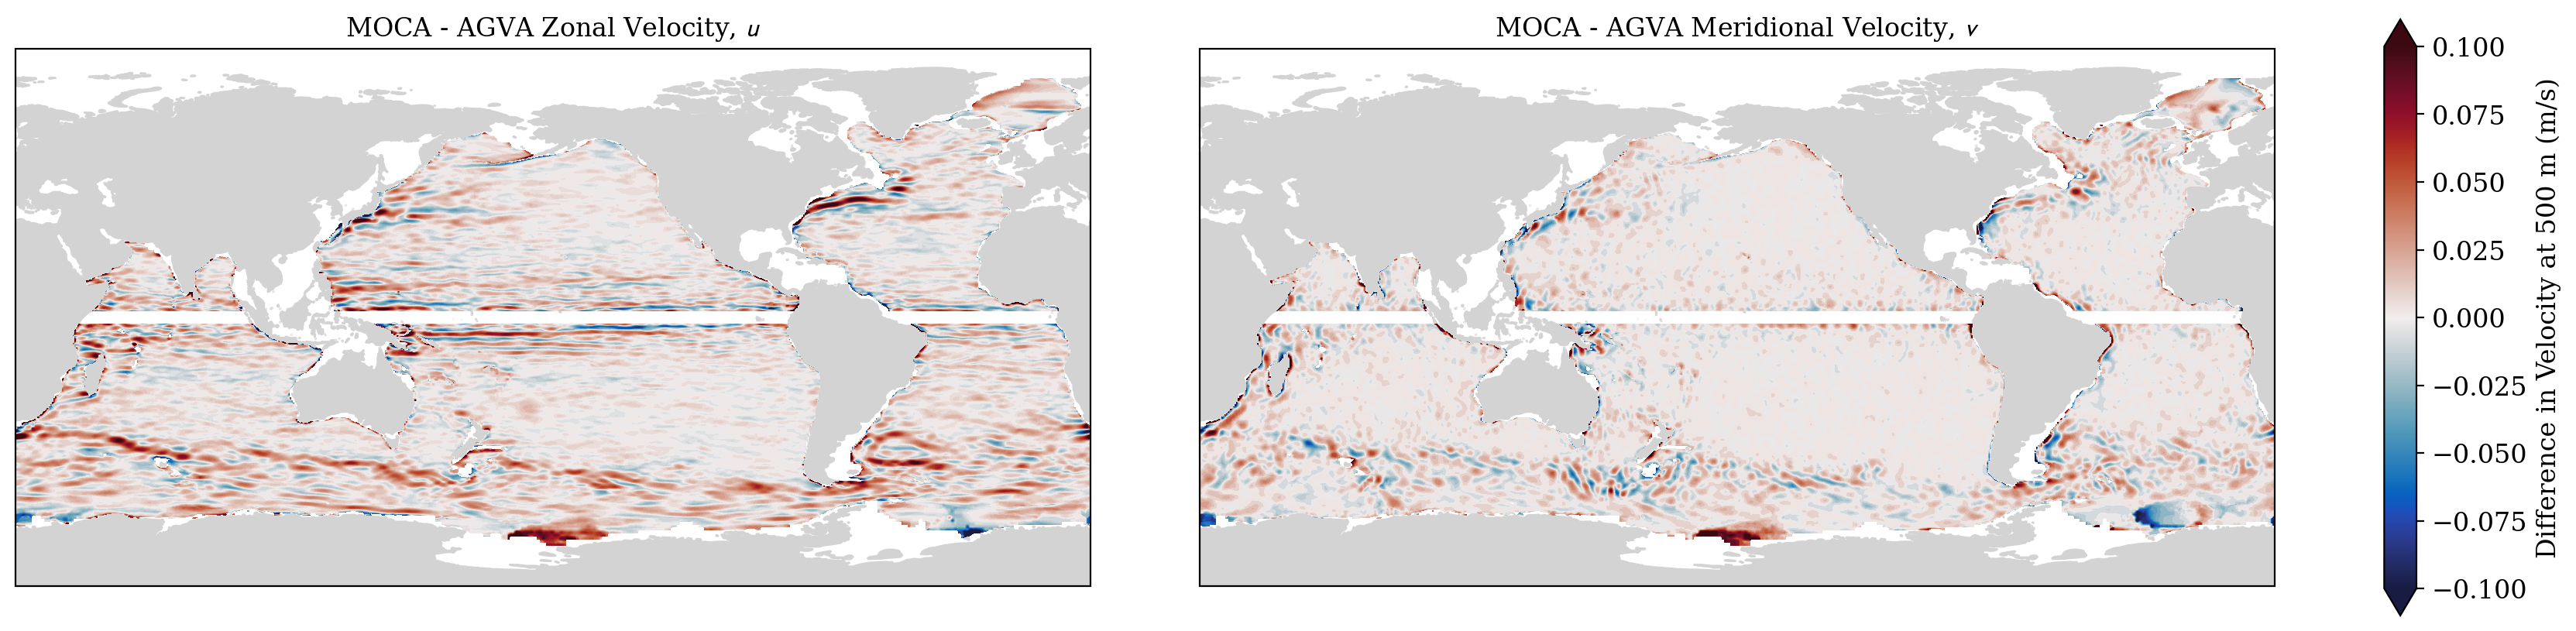

In [79]:
plot_argo_moca_diffs(500, cbarlims=[-0.1,0.1])


(641, 719) (719,)
(721,) (641,) (641, 721)
(721,) (641,) (641, 721)


C:\Users\annab\AppData\Local\Temp\ipykernel_15544\3772708213.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


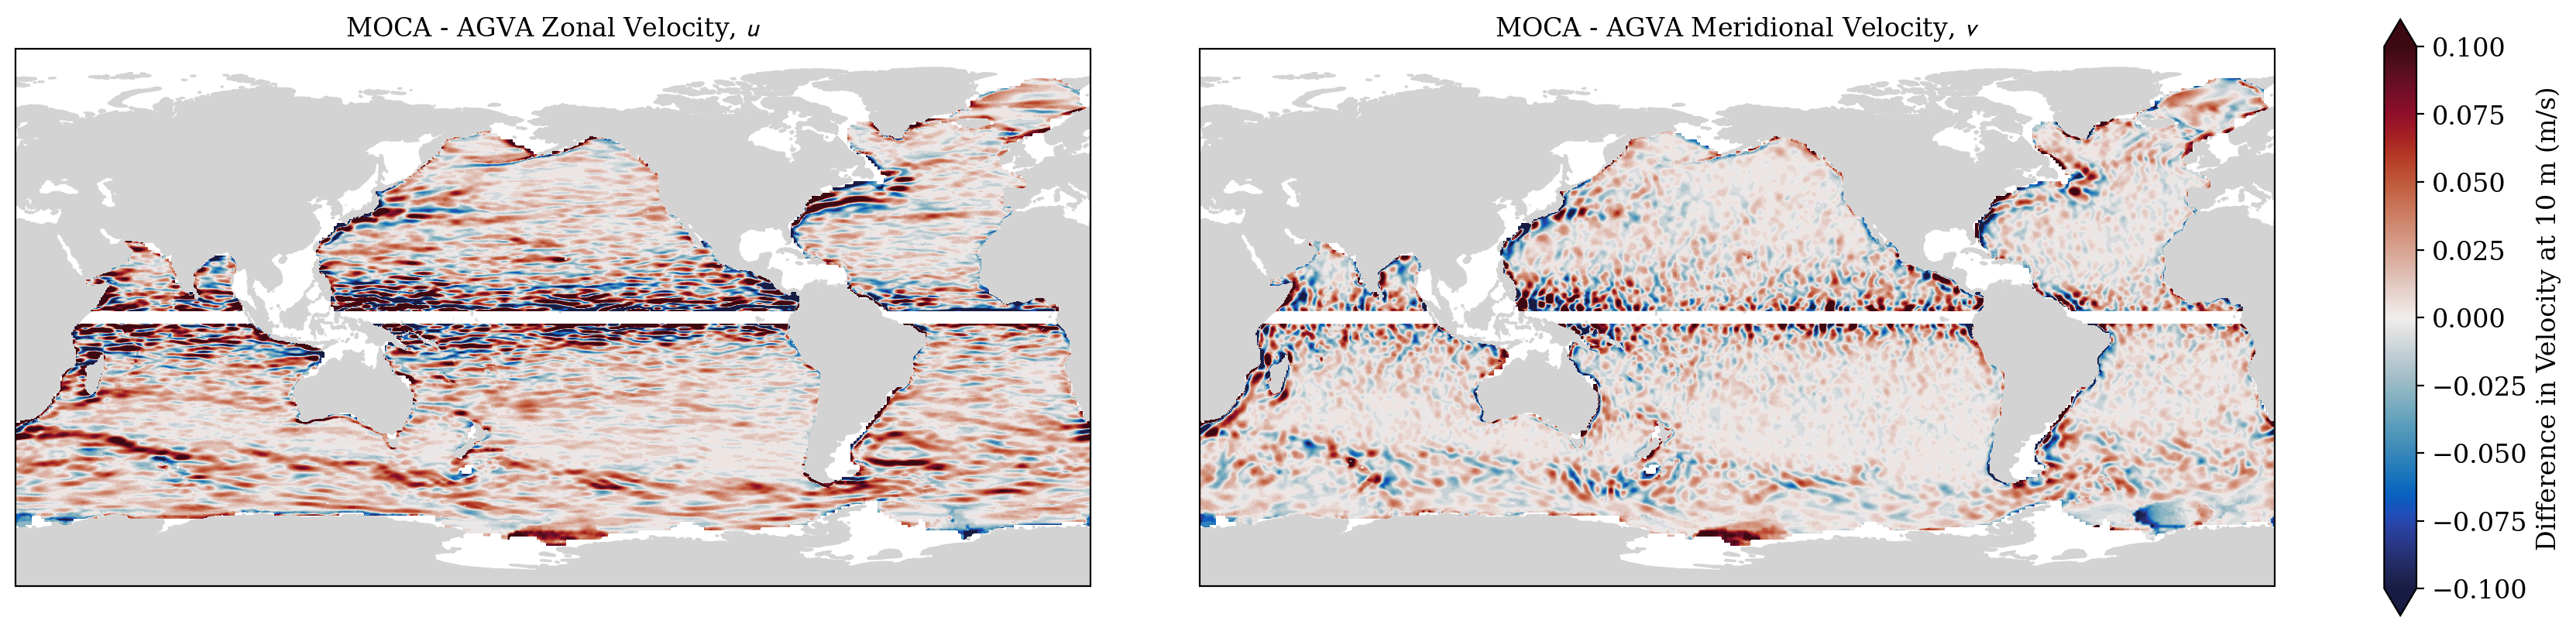

(641, 719) (719,)
(721,) (641,) (641, 721)
(721,) (641,) (641, 721)


C:\Users\annab\AppData\Local\Temp\ipykernel_15544\3772708213.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


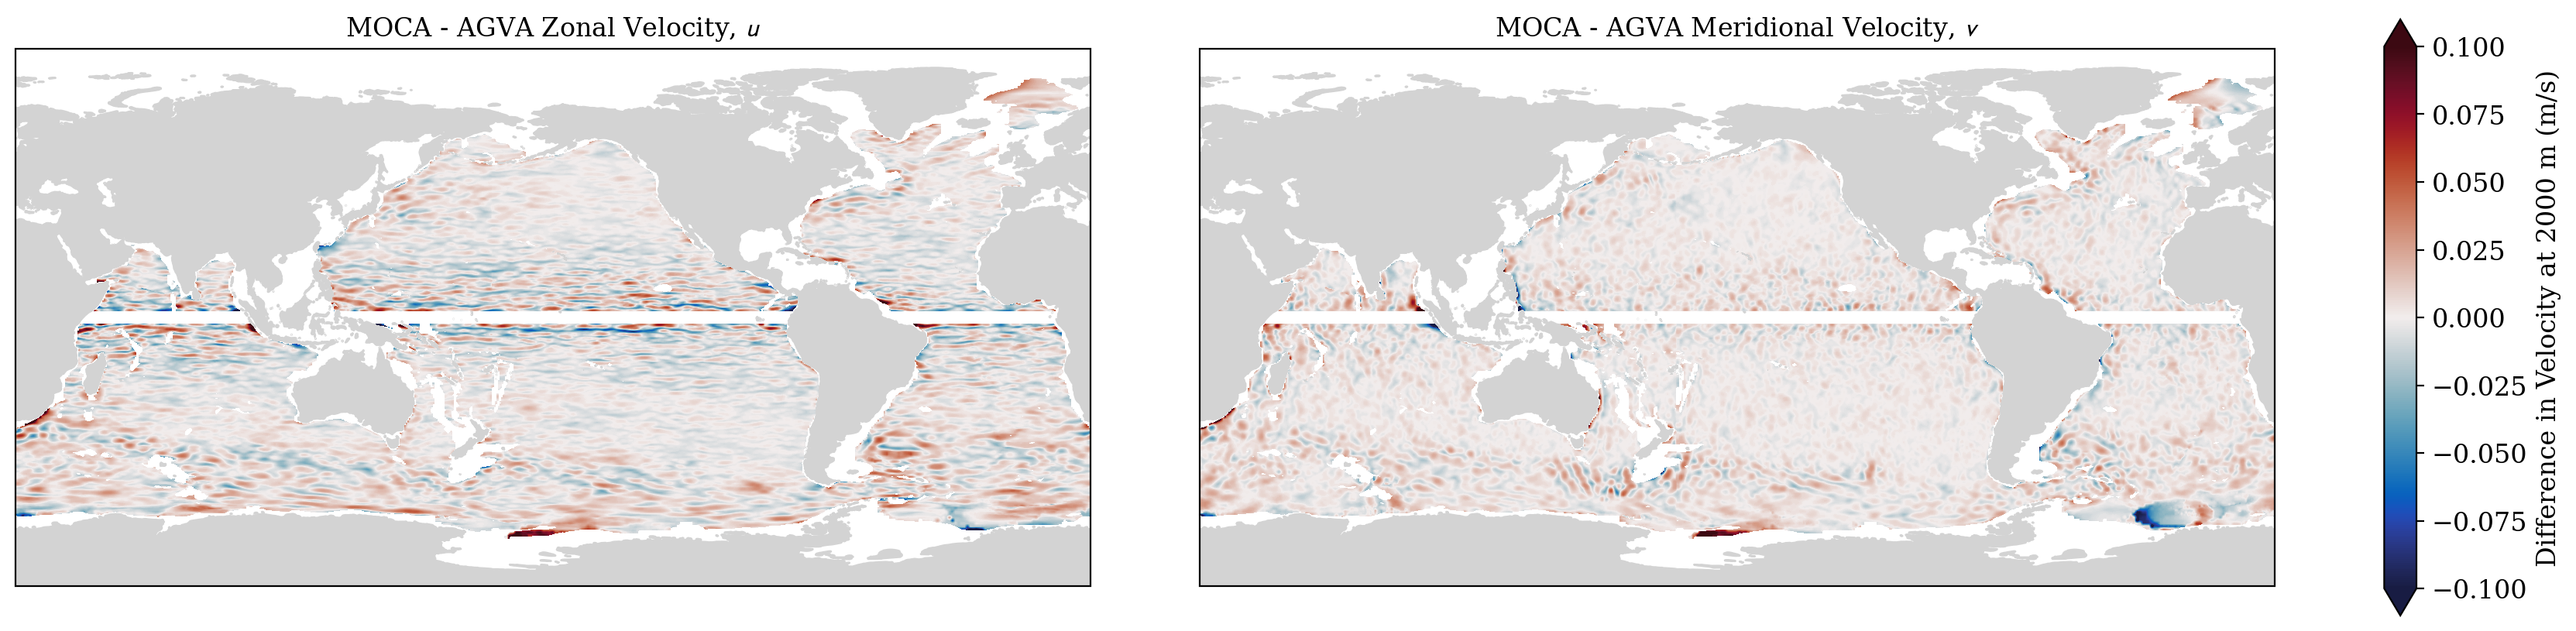

In [80]:
plot_argo_moca_diffs(10, cbarlims=[-0.1,0.1])
# plot_argo_moca_diffs(250, cbarlims=[-0.1,0.1])
plot_argo_moca_diffs(2000, cbarlims=[-0.1,0.1])